# Physics-Informed Neural Networks

Original [paper](https://www.sciencedirect.com/science/article/pii/S0021999118307125) by M.Raissi et al. 

In complex physical, biological or engineering systems, obtaining data is sometimes unachievable. State of the art machine learning techniques cannot provide any guarantee of convergence given the lack of training data. 

**Traditional physics model** creation is a task of a domain expert, who parametrises physics models to best fit a system of interest. For example, creating a model of aircraft dynamics using equations of drag, lift, gravity, thrust, etc., and parametrising the model to attempt to closely match the model to a specific aircraft.

However, sometimes physical systems are hard to parametrise and there does not exist a closed form solution. 

In [1]:
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 8})

import jax
import jax.numpy as jnp
from jax import value_and_grad, jit, random, vmap
import optax

from tqdm import tqdm

KEY = random.PRNGKey(1)

## The Solution to the Shrodinger Equation

As an example to illustrate how PINNs are applied, we will look at the solution to the non-linear Shrodinger equation.

The non-linear Shrodinger equation, along with its periodic boundary conditions is given by: $$i\frac{\partial h(x, t)}{\partial t} + 0.5 \frac{\partial^2 h(x, t)}{\partial x \partial x} + |h(x, t)|^2h(x, t) = 0$$ $$h(x, 0) = 2 sech(x)$$ $$h(-5, t) = h(5, t)$$ $$\frac{\partial h(-5, t)}{\partial x} = \frac{\partial h(5, t)}{\partial x}$$

The complex valued solution of the non-linear Schrodinger equaton is denoted as $$h(x, t), x\in[-5, 5], t \in [0, \pi/2]$$ The output of $h(x, t)$ will be $u + iv$, where $u$ is the real part and $v$ is the imaginary part. To better understand the solution and for easier visualization, we will inspect the norm of our solution $|h(x,t)| = \sqrt{u^2 + v^2}$ for the rest of the homework.

Below, we will import our dataset associated with the Shrodinger equation. The data include input values $x, t$ and it's corresponding output values $u, v$ pair. Please just run the following cells.

In [2]:
data = scipy.io.loadmat("original_paper/Data/NLS.mat")

# Global variables
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])
N0 = 50
N_b = 50
N_f = 20000

# Original data (including training and validation)
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
u = np.real(data['uu'])
v = np.imag(data['uu'])
h = np.sqrt(u**2 + v**2)

# Initial Condition Data (N = 50)
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
t0 = np.zeros(x0.shape)
u0 = u[idx_x,0:1]
v0 = v[idx_x,0:1]
X0 = np.concatenate([x0, t0], axis=1)
Y0 = np.concatenate([u0, v0], axis=1)

# Boundary Condition Data (N = 50 + 50)
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]
t_ub = t_lb = tb
X_ub = np.concatenate([np.zeros(tb.shape) + ub[0], t_ub], axis=1)
X_lb = np.concatenate([np.zeros(tb.shape) + lb[0], t_lb], axis=1)
Xb = np.concatenate([X_ub, X_lb])
u_lb = u[0, idx_t][..., None]
u_ub = u_lb
v_lb = v[0, idx_t][..., None]
v_ub = v_lb
Y_ub = np.concatenate([u_ub, v_ub], axis=1)
Y_lb = np.concatenate([u_lb, v_lb], axis=1)
Yb = np.concatenate([Y_ub, Y_lb])

# Training data (N = 50 + (50 + 50))
X = np.concatenate([X0, Xb])
Y = np.concatenate([Y0, Yb])

In [3]:
print(f"Initial condition training data. X0: {X0.shape}, Y0: {Y0.shape}")
print(f"Boundary condition training data. Xb: {Xb.shape}, Yb: {Yb.shape}")
print(f"Total training data. X: {X.shape}, Y: {Y.shape}")

Initial condition training data. X0: (50, 2), Y0: (50, 2)
Boundary condition training data. Xb: (100, 2), Yb: (100, 2)
Total training data. X: (150, 2), Y: (150, 2)


Note that we only have 150 training data. In reality, with reasonable effort, we could only obtain the data at the initial and boundary conditions of the Shrodinger equation. The initial condition is when $t=0$, and the boundary condition is when $x=-5$ or $x=5$. 

In the paper, we are limited with 50 data points at the initial condition, 50 data points at the upper boundary condition, and 50 data points at the lower boundary condition. Combined, we have 150 data points to train our neural network. This is not desired, and we will see how vanilla MLP will perform in a low-data regime.


### Visualizing our full data

Before training our neural network, let us visualize how our full data look like. The full data include data that is not limited to our initial and boundary conditions. As mentioned above, we will visualize the complex valued solution through $|h(x, t)|$. 

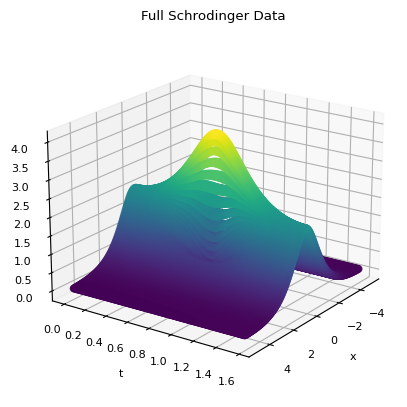

In [4]:
t_grid, x_grid = np.meshgrid(t,x)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(20, 35)
ax.scatter(x_grid, t_grid, h, c=h, cmap='viridis')
ax.set(xlabel="x", ylabel="t", title="Full Schrodinger Data");

### Visualizing our training data on initial condition (t=0)

Now let us visualize the solution of our training data at the initial condition. We will visualize the real and imaginary part of our solution seperately

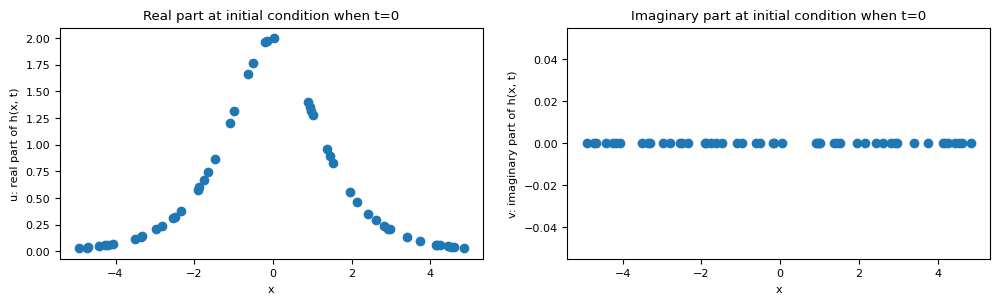

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].scatter(X0[:, 0], Y0[:, 0])
axs[1].scatter(X0[:, 0], Y0[:, 1])
axs[0].set(xlabel="x", ylabel="u: real part of h(x, t)", title="Real part at initial condition when t=0")
axs[1].set(xlabel="x", ylabel="v: imaginary part of h(x, t)", title="Imaginary part at initial condition when t=0");

### Visualizing our training data on boundary condition (x=-5 and x=5)

Now let us visualize the solution at the boundary conditions. Note that the solution for $h(-5, t)$ and $h(5, t)$ for all $t \in [0, \pi/2]$ is exactly the same.

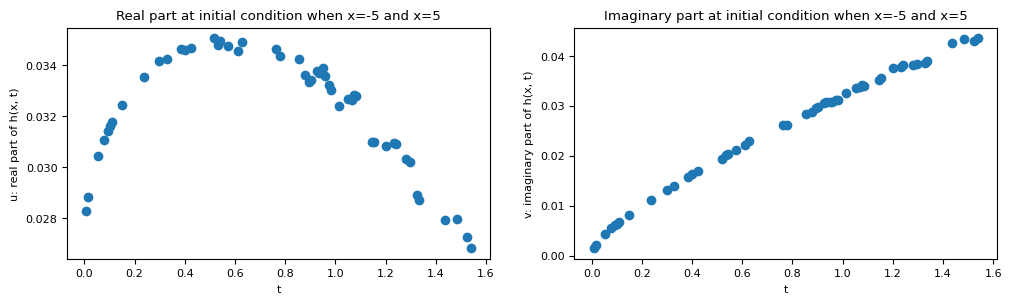

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].scatter(Xb[:50, 1], Yb[:50, 0])
axs[1].scatter(Xb[:50, 1], Yb[:50, 1])
axs[0].set(xlabel="t", ylabel="u: real part of h(x, t)", title="Real part at initial condition when x=-5 and x=5")
axs[1].set(xlabel="t", ylabel="v: imaginary part of h(x, t)", title="Imaginary part at initial condition when x=-5 and x=5");

## Vanilla MLP

Ok! We are ready to find the solution of the Shrodinger equation using traditional neural network architectures.

In traditional data-driven methods, we are trying to find the solution h(x,t) using a neural network and our training data described above. Here, according to the paper, the architecture is a traditional 5-layer MLP with $\tanh$ as activation functions. Specifically: $$NN(X) = W^{(5)}(\tanh(W^{(4)}\tanh(\dots) + b^{(4)})) + b^{(5)}$$ where $X = [x, t]$ is our input vector of shape (2), and $W^{(n)}, b^{(n)}$ indicate the weights and biases at each layer. 

According to the paper, the dimension for each layer is: $[2, 100, 100, 100, 100, 2]$. The output is of shape (2) in the form of $[u, v]$, the real and imaginary part of $h(x, t)$.

First implement `init_params` and `vanilla_forward`.

In [7]:
def init_params(layers, key=KEY):
    '''
    Initialize parameters in the MLP. Weights are initialized
    using Xavier initialization, while biases are zero initialized.

    Arguments
    - layers: A list indicating the dimension of each individual
      imbedding at layers of MLP. For example: [1, 10, 1] would
      indicate a simple 2 layer MLP. 

    Returns
    - params: the initialized parameters. For example, 
      [(w_1, b_1), (w_2, b_2)] is a valid output.
    '''
    def xavier_init(input_dim, output_dim, key=key):
        '''Use Xavier initialization for weights of a single layer'''
        w = None
        # ===== START OF YOUR CODE =====
        # compute standard deviation for xavier init
        # recall it is given by sqrt{2 /(?)}
        std_dev = jnp.sqrt(2/(input_dim + output_dim)) # TODO: compute standard deviation
        w = std_dev * random.normal(key, (input_dim, output_dim)) # TODO: initialize the weights
        # ===== END OF YOUR CODE =====
        return w

    params = []

    # ===== START OF YOUR CODE =====
    for l in range(len(layers) - 1): # TODO
        w = xavier_init(layers[l], layers[l+1]) # TODO: xavier initialize the weight
        b = jnp.zeros(layers[l+1]) # TODO: zero initialize the bias
        params.append((w, b)) # TODO: append weight and bias for this layer to params
    # ===== END OF YOUR CODE =====
    
    return params


def vanilla_forward(params, x):
    '''
    Forward pass through the vanilla MLP. In PINN, the nonlinearity are
    applied using tanh.

    Arguments
    - params: weights and biases for all layers of the vanilla MLP.
      For example, [(w_1, b_1), (w_2, b_2)] is a valid input.
    - x: input to the vanilla MLP

    Returns
    - out: output of the vanilla MLP
    '''
    activations = x

    # ===== START OF YOUR CODE =====
    # Create a for loop to loop over the parameters EXCEPT
    # the parameters corresponding to the very last layer.
    # This is because we will not be applying the nonlinearity
    # to the output of the last layer (which is out prediction).
    for w, b in params[:-1]: # TODO
        out = jnp.dot(activations, w) + b # TODO: Perform linear operation
        activations = jnp.tanh(out) # TODO: apply tanh activation
    
    final_w, final_b = params[-1] # TODO
    out = jnp.dot(activations, final_w) + final_b # TODO: Do not apply nonlinearity to last layer
    # ===== END OF YOUR CODE =====
    return out

# Use vmap to perform in parallel (jax magic)
vanilla_batched_forward = vmap(vanilla_forward, in_axes=(None, 0))

Test implementation for `init_param` and `vanilla_forward`.

In [8]:
layers = [2, 10, 1]
x = random.uniform(KEY, (5, 2))
out = vanilla_batched_forward(init_params(layers), x)
expected = jnp.array([[-0.05742961],
                      [-0.08960884],
                      [-0.04750253],
                      [-0.17843515],
                      [-0.09102767]])
assert jnp.allclose(out, expected)
print("Test passed!")

Test passed!


Now implement `vanilla_mseloss` and `step`.

In [9]:
def vanilla_mseloss(params, x, y):
    '''
    Compute mean squared error between x and y

    Arguments
    - layers: all params for the MLP
    - x: input to the MLP
    - y: true label
    '''
    loss = None
    # ===== START OF YOUR CODE =====
    pred = vanilla_batched_forward(params, x) # TODO: use `vanilla_batched_forward` to make prediction
    loss = jnp.mean(jnp.square(pred - y)) # TODO
    # ===== END OF YOUR CODE =====
    return loss

def vanilla_fit(params, optimizer, X, Y):
    '''
    Train the vanilla MLP using training data X and Y with a given optimizer.
    
    Arguments:
    - params: weights and biases for all layers of the MLP.
    - optimizer: An optax optimizer.
    - X: Input to the model.
    - Y: Labels.
    
    Returns:
    Trained parameters.
    '''
    opt_state = optimizer.init(params)

    @jit
    def step(params, opt_state, x, y):
        '''
        A single step of our training algorithm.
        
        Arguments:
        - params: weights and biases for all layers.
        - opt_state: Optimizer state.
        - x: One input.
        - y: One label
        
        Returns:
        - params: updated parameters
        - opt_State: updated optimizer state
        - loss_value: loss of this run
        '''
        # ===== START OF YOUR CODE =====
        loss_value, grads = value_and_grad(vanilla_mseloss)(params, x, y) # TODO: check out `value_and_grad` using jax doc
        updates, opt_state = optimizer.update(grads, opt_state, params) # TODO: check out `optimizer.update()` using jax doc
        params = optax.apply_updates(params, updates) # TODO: check out `apply_updates()` using jax doc
        # ===== END OF YOUR CODE =====
        return params, opt_state, loss_value

    for epoch in tqdm(range(1000)):
        for (x, y) in zip(X, Y):
            # ===== START OF YOUR CODE =====
            params, opt_state, loss_value = step(params, opt_state, x, y) # TODO: Execute one step of fitting
            # ===== END OF YOUR CODE =====

    return params

Now, it is time to train the vanilla MLP! We will train it with 1000 epochs. It will take approx 2 minutes.

In [10]:
layers = [2, 100, 100, 100, 100, 2]
optimizer = optax.adam(learning_rate=5e-4)

# ===== START OF YOUR CODE =====
vanilla_trained_params = vanilla_fit(init_params(layers), optimizer, X, Y) # TODO: fit your vanilla MLP
# ===== END OF YOUR CODE =====

100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.77it/s]


### Visualize your training result

First visualize the performance on the training data. Note: It will look quite messy.

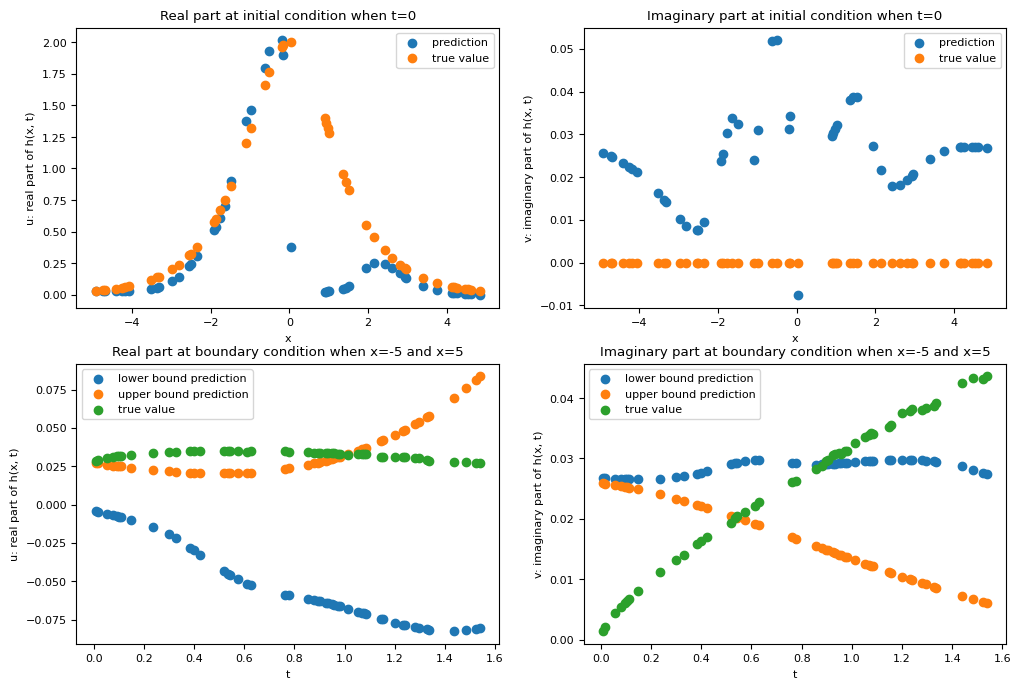

In [11]:
# ===== START OF YOUR CODE =====
pred = vanilla_batched_forward(vanilla_trained_params, X) # TODO: make prediction using `vanilla_trained_params`
# ===== END OF YOUR CODE =====

fig, axs = plt.subplots(2,2, figsize=(12, 8))
axs[0,0].scatter(X[:50, 0], pred[:50, 0], label="prediction")
axs[0,0].scatter(X[:50, 0], Y0[:, 0], label="true value")
axs[0,0].legend()
axs[0,1].scatter(X[:50, 0], pred[:50, 1], label="prediction")
axs[0,1].scatter(X[:50, 0], Y0[:, 1], label="true value")
axs[0,1].legend()
axs[0,0].set(xlabel="x", ylabel="u: real part of h(x, t)", title="Real part at initial condition when t=0")
axs[0,1].set(xlabel="x", ylabel="v: imaginary part of h(x, t)", title="Imaginary part at initial condition when t=0")
axs[1,0].scatter(X[50:100, 1], pred[50:100, 0], label="lower bound prediction")
axs[1,0].scatter(X[100:, 1], pred[100:, 0], label="upper bound prediction")
axs[1,0].scatter(X[50:100, 1], Yb[0:50, 0], label="true value")
axs[1,0].legend()
axs[1,1].scatter(X[50:100, 1], pred[50:100, 1], label="lower bound prediction")
axs[1,1].scatter(X[100:, 1], pred[100:, 1], label="upper bound prediction")
axs[1,1].scatter(X[50:100, 1], Yb[0:50, 1], label="true value")
axs[1,1].legend()
axs[1,0].set(xlabel="t", ylabel="u: real part of h(x, t)", title="Real part at boundary condition when x=-5 and x=5")
axs[1,1].set(xlabel="t", ylabel="v: imaginary part of h(x, t)", title="Imaginary part at boundary condition when x=-5 and x=5");

Now visualize the performance on the full data. Note: It will look quite messy.

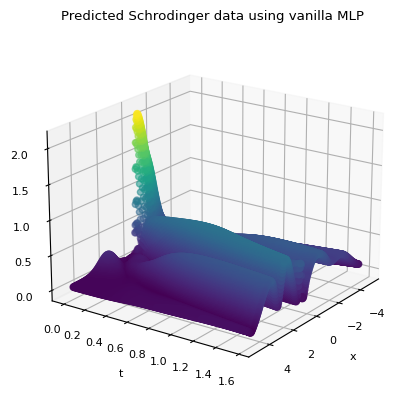

In [12]:
t_all = t_grid.flatten()[..., None]
x_all = x_grid.flatten()[..., None]
X_all = np.concatenate([x_all, t_all], axis=1)

pred = vanilla_batched_forward(vanilla_trained_params, X_all)
h_pred_vanilla = np.sqrt(pred[:,0]**2 + pred[:,1]**2)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(20, 35)
ax.scatter(x_all, t_all, h_pred_vanilla, c=h_pred_vanilla, cmap='viridis')
ax.set(xlabel="x", ylabel="t", title="Predicted Schrodinger data using vanilla MLP");

In [13]:
vanilla_prediction_error = jnp.mean(jnp.square(h_pred_vanilla - h.flatten()))
print(f"The total validation error for the vanilla MLP is: {vanilla_prediction_error}")

The total validation error for the vanilla MLP is: 0.5263756513595581


## PINN

You might notice that we haven't really used any knowledge about the Schrodinger equation when training the vanilla MLP. We are simply feeding out training data, treating the MLP as a black box and trust its power to approximate the Schrodinger's solution.

But since we only have 150 training data points, our vanilla MLP cannot reach an optimized result. Thus, we now look at how to incorporate our knowledge on the Shrodinger's equation in to our vanilla MLP architecture.

To begin, we need to slightly modify the `forward` function to follow some conventions of `JAX`.

1. We want our `forward` function to return scalar values so the `JAX` library can take the gradients easily. Since currently, our implementation of `forward` returns $[u, v]$, we need to split our forward function into two.
2. We also want to pass our inputs into the `forward` function seperatly. Previously, we are feeding in $[x, t]$. Now, we need to feed them in seperately.

In [14]:
def pinn_forward_u(params, x, t):
    '''
    Forward pass through the PINN that outputs u(the real part of the result).
    Notice that we create two forward functions for u(real part) and v(imaginary part) seperately
    because in order for JAX to do auto-grad, the function must output a scalar value, not a tuple.
    
    The nonlinearity used here is tanh.
    
    Arguments
    - params: weights and biases for all layers of the vanilla MLP.
      For example, [(w_1, b_1), (w_2, b_2)] is a valid input.
    - x: input to PINN
    - t: input to PINN

    Returns
    - out: real part of the output of PINN
    '''
    activations = jnp.hstack([x, t])
    
    # ===== START OF YOUR CODE =====
    for w, b in params[:-1]: # TODO
        out = jnp.dot(activations, w) + b # TODO: Perform linear operation
        activations = jnp.tanh(out) # TODO: apply tanh activation
    
    final_w, final_b = params[-1] # TODO
    out = jnp.dot(activations, final_w) + final_b # TODO: Do not apply nonlinearity to last layer
    # ===== END OF YOUR CODE =====
    return out[0]
  
def pinn_forward_v(params, x, t):
    '''
    Forward pass through the PINN that outputs v(the imaginary part of the result).
    Notice that we create two forward functions for u(real part) and v(imaginary part) seperately
    because in order for JAX to do auto-grad, the function must output a scalar value, not a tuple.
    
    The nonlinearity used here is tanh.

    Arguments
    - params: weights and biases for all layers of the vanilla MLP.
      For example, [(w_1, b_1), (w_2, b_2)] is a valid input.
    - x: input to PINN
    - t: input to PINN

    Returns
    - out: imaginary part of the output of PINN
    '''
    activations = jnp.hstack([x, t])
    
    # ===== START OF YOUR CODE =====
    for w, b in params[:-1]: # TODO
        out = jnp.dot(activations, w) + b # TODO: Perform linear operation
        activations = jnp.tanh(out) # TODO: apply tanh activation
    
    final_w, final_b = params[-1] # TODO
    out = jnp.dot(activations, final_w) + final_b # TODO: Do not apply nonlinearity to last layer
    # ===== END OF YOUR CODE =====
    return out[1]

pinn_batched_forward_u = vmap(pinn_forward_u, in_axes=(None, 0, 0))
pinn_batched_forward_v = vmap(pinn_forward_v, in_axes=(None, 0, 0))

In [15]:
# pinn forward test
result = pinn_batched_forward_u(vanilla_trained_params, X[:,0], X[:,1])
expected = vanilla_batched_forward(vanilla_trained_params, X)[:, 0]
assert jnp.allclose(result, expected)

result = pinn_batched_forward_v(vanilla_trained_params, X[:,0], X[:,1])
expected = vanilla_batched_forward(vanilla_trained_params, X)[:, 1]
assert jnp.allclose(result, expected)
print("Test passed!")

Test passed!


Here comes the most important part of the homework. The essence of incorporating the Schrodinger's equation into the architecture is through modifying the loss functions. Recall in the Schrodinger's data, we can classify our data into three categories: the initial conditions, the boundary conditions, and the "normal" data. Let's look at them individually.

### MSE Loss designed for initial condition $MSE_0$

This is the simplest case. Since we have labeled training data, we will just use the traditional MSE loss. Nothing changed.

### MSE Loss designed for boundary condition $MSE_b$

In this case, thing got a bit more interesting. We also have labeled training data. But on top of that, the Shrodinger's equation states that $$h(-5, t) = h(5, t)$$ $$\frac{\partial h(-5, t)}{\partial x} = \frac{\partial h(5, t)}{\partial x}$$ In other words, the solution and the derivative of our solution with respect to $x$ should be symmetrical! We can incorporate this knowlegde by designing optimizer to minimize $MSE_b$ defined as: $$MSE_b := \frac{1}{N}\sum^N_{i=0}\left[\|h(-5, t_i) - h(5, t_i)\|^2 + \|\frac{\partial}{\partial x}h(-5, t_i) - \frac{\partial}{\partial x}h(5, t_i)\|^2\right]$$

### MSE Loss designed for "normal" $MSE_f$

The most intereting case. In "normal" case, we do not have labeled data. However, it turns out we can design a loss function that will motivate our neural network to obey the Shrodinger's equation where we do have labeled data. Specifically, $$i\frac{\partial h(x, t)}{\partial t} + 0.5 \frac{\partial^2 h(x, t)}{\partial x \partial x} + |h(x, t)|^2h(x, t) = 0$$ By looking at the equation, we can see that the desired outcome for the LHS is zero. Therefore, if we define the LHS of the equation as $$f(x, h):= i\frac{\partial h(x, t)}{\partial t} + 0.5 \frac{\partial^2 h(x, t)}{\partial x \partial x} + |h(x, t)|^2h(x, t)$$, we can design the following loss function to minimize: $$MSE_f := \frac{1}{N}\sum^N_{i=0}\|f(x_i, t_i)\|^2$$

During traning, the optimizer will aim to make $f(x,h) = 0$ to minimize $MSE_f$, which is exactly what we desire.

### Conclusion

$$MSE = MSE_0 + MSE_b + MSE_f$$ 

$$MSE_0 := \frac{1}{N}\sum^N_{i=0}\|h(x_i, t_i) - h_i\|$$

$$MSE_b := \frac{1}{N}\sum^N_{i=0}\left[\|h(-5, t_i) - h(5, t_i)\|^2 + \|\frac{\partial}{\partial x}h(-5, t_i) - \frac{\partial}{\partial x}h(5, t_i)\|^2\right]$$

$$MSE_f := \frac{1}{N}\sum^N_{i=0}\|f(x_i, t_i)\|^2$$

In [16]:
def pinn_mseloss(params, x, t, u_true, v_true):
    '''
    Compute the MSE Loss of the PINN. Following the Schrodinger's
    equation, the MSE Loss is a combination of 3 mse losses:
    mse_zero, mse_boundary, and mse_f.
    
    Arguments:
    - params: weights and biases for all layers of the PINN.
    - x, t, u_true, v_true: input to the PINN
    
    Returns: A combined MSE Loss.
    '''
    
    # ===== START OF YOUR CODE =====
    u = pinn_forward_u(params, x, t)  # TODO: do a forward pass
    v = pinn_forward_v(params, x, t)

    # TODO: Compute mseloss_0
    mseloss_zero = jnp.mean(jnp.square(u - u_true)) + \
                   jnp.mean(jnp.square(v - v_true))   

    
    # TODO: Compute mseloss_boundary
    x_opposite = jnp.abs(x)
    u_opposite = pinn_forward_u(params, x_opposite, t) 
    v_opposite = pinn_forward_v(params, x_opposite, t)
    u_x, u_t = jax.jacrev(pinn_forward_u, argnums=(1, 2))(params, x, t) # TODO: Compute du/dx anddu/dt; Hint: use jacobian reversed
    v_x, v_t = jax.jacrev(pinn_forward_v, argnums=(1, 2))(params, x, t)
    u_x_opposite = jax.jacrev(pinn_forward_u, argnums=(1))(params, x_opposite, t)
    v_x_opposite = jax.jacrev(pinn_forward_v, argnums=(1))(params, x_opposite, t)

    mseloss_boundary = jnp.mean(jnp.square(u - u_opposite)) + \
                       jnp.mean(jnp.square(v - v_opposite)) + \
                       jnp.mean(jnp.square(u_x - u_x_opposite)) + \
                       jnp.mean(jnp.square(v_x - v_x_opposite)) 

    # TODO: Compute mseloee_f
    # Hint: Follow the equation above
    u_xx = jax.jacrev(jax.jacrev(pinn_forward_u, argnums=(1)), argnums=1)(params, x, t)
    v_xx = jax.jacrev(jax.jacrev(pinn_forward_v, argnums=(1)), argnums=1)(params, x, t)
    f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
    f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u

    mseloss_f = jnp.mean(f_u**2) + jnp.mean(f_v**2)

    loss = mseloss_zero + mseloss_f + mseloss_boundary # TODO: Combine all 3 losses to get the final loss
    # ===== END OF YOUR CODE =====

    return loss


def pinn_fit(params, optimizer, X, Y):
    '''
    Train PINN using training data X and Y with a given optimizer.
    
    Arguments:
    - params: weights and biases for all layers of the PINN.
    - optimizer: An optax optimizer.
    - X: Input of the PINN
    - Y: Labels
    
    Returns:
    Trained parameters.
    '''
    opt_state = optimizer.init(params)

    @jit
    def step(params, opt_state, x, t, u_true, v_true):
        '''
        A single step of our training algorithm.
        
        Arguments:
        - params: weights and biases for all layers.
        - opt_state: Optimizer state.
        - x: One input.
        - y: One label
        
        Returns:
        - params: updated parameters
        - opt_State: updated optimizer state
        - loss_value: loss of this run
        '''
        # ===== START OF YOUR CODE =====
        loss_value, grads = value_and_grad(pinn_mseloss)(params, x, t, u_true, v_true) # TODO: check out `value_and_grad` using jax doc
        updates, opt_state = optimizer.update(grads, opt_state, params) # TODO: check out `optimizer.update()` using jax doc
        params = optax.apply_updates(params, updates) # TODO: check out `apply_updates()` using jax doc
        # ===== END OF YOUR CODE =====
        return params, opt_state, loss_value

    for epoch in tqdm(range(1000)):
        for (x, y) in zip(X, Y):
            # ===== START OF YOUR CODE =====
            x, t = x[0], x[1]
            u_true, v_true = y[0], y[1]
            params, opt_state, loss_value = step(params, opt_state, x, t, u_true, v_true) # TODO: run one step
            # ===== END OF YOUR CODE =====

    return params

Let's train our PINN! This will take approximately 5 minutes.

In [17]:
layers = [2, 100, 100, 100, 100, 2]
optimizer = optax.adam(learning_rate=5e-4)

# ===== START OF YOUR CODE =====
pinn_trained_params = pinn_fit(init_params(layers), optimizer, X, Y) # TODO: train the PINN
# ===== END OF YOUR CODE =====

100%|██████████████████████████████████████████████████████████████| 1000/1000 [01:11<00:00, 14.08it/s]


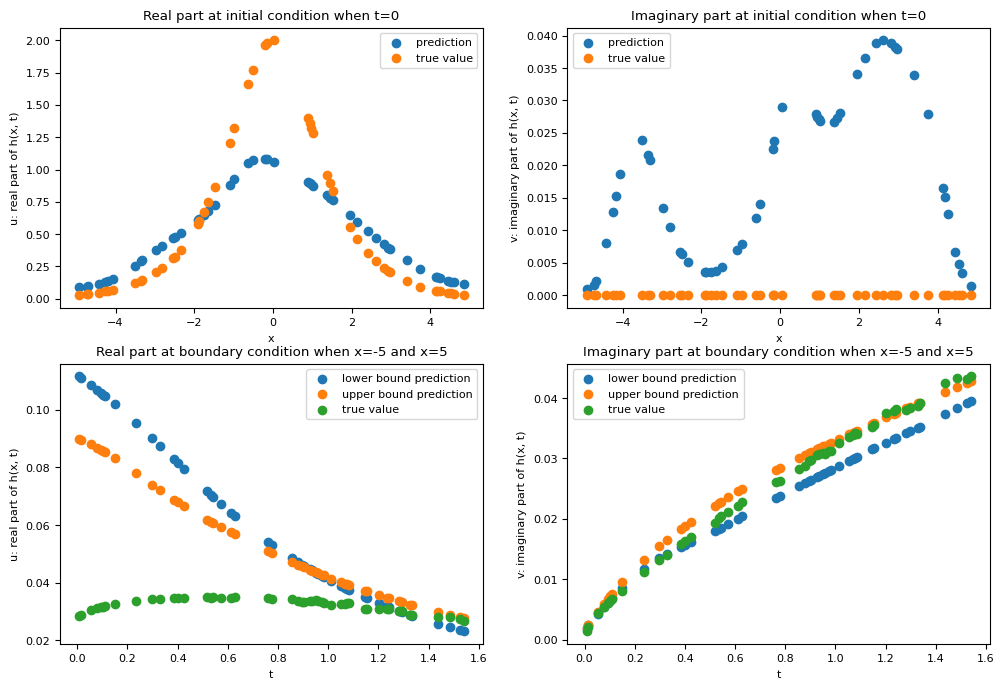

In [18]:
# ===== START OF YOUR CODE =====
pred = vanilla_batched_forward(pinn_trained_params, X) # TODO: make prediction using `trained_params`
# ===== END OF YOUR CODE =====

fig, axs = plt.subplots(2,2, figsize=(12, 8))
axs[0,0].scatter(X[:50, 0], pred[:50, 0], label="prediction")
axs[0,0].scatter(X[:50, 0], Y0[:, 0], label="true value")
axs[0,0].legend()
axs[0,1].scatter(X[:50, 0], pred[:50, 1], label="prediction")
axs[0,1].scatter(X[:50, 0], Y0[:, 1], label="true value")
axs[0,1].legend()
axs[0,0].set(xlabel="x", ylabel="u: real part of h(x, t)", title="Real part at initial condition when t=0")
axs[0,1].set(xlabel="x", ylabel="v: imaginary part of h(x, t)", title="Imaginary part at initial condition when t=0")
axs[1,0].scatter(X[50:100, 1], pred[50:100, 0], label="lower bound prediction")
axs[1,0].scatter(X[100:, 1], pred[100:, 0], label="upper bound prediction")
axs[1,0].scatter(X[50:100, 1], Yb[0:50, 0], label="true value")
axs[1,0].legend()
axs[1,1].scatter(X[50:100, 1], pred[50:100, 1], label="lower bound prediction")
axs[1,1].scatter(X[100:, 1], pred[100:, 1], label="upper bound prediction")
axs[1,1].scatter(X[50:100, 1], Yb[0:50, 1], label="true value")
axs[1,1].legend()
axs[1,0].set(xlabel="t", ylabel="u: real part of h(x, t)", title="Real part at boundary condition when x=-5 and x=5")
axs[1,1].set(xlabel="t", ylabel="v: imaginary part of h(x, t)", title="Imaginary part at boundary condition when x=-5 and x=5");

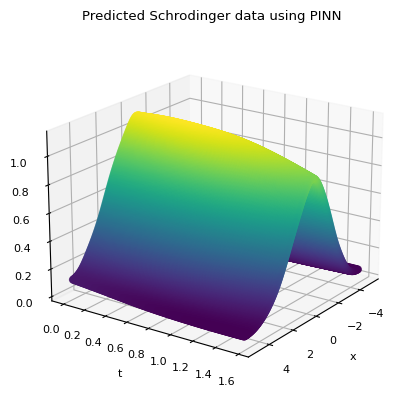

In [19]:
t_all = t_grid.flatten()[..., None]
x_all = x_grid.flatten()[..., None]
X_all = np.concatenate([x_all, t_all], axis=1)

pred = vanilla_batched_forward(pinn_trained_params, X_all)
h_pred_pinn = np.sqrt(pred[:,0]**2 + pred[:,1]**2)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(20, 35)
ax.scatter(x_all, t_all, h_pred_pinn, c=h_pred_pinn, cmap='viridis')
ax.set(xlabel="x", ylabel="t", title="Predicted Schrodinger data using PINN");

In [20]:
pinn_prediction_error = jnp.mean(jnp.square(h_pred_pinn - h.flatten()))
print(f"The total validation error for the PINN is: {pinn_prediction_error}")
print(f"The total validation error for the vanilla MLP is: {vanilla_prediction_error}")

The total validation error for the PINN is: 0.19929341971874237
The total validation error for the vanilla MLP is: 0.5263756513595581


We're done! You should observe a lower validation error using PINN.

## Reference

M. Raissi, P. Perdikaris, G.E. Karniadakis, Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations, Journal of Computational Physics, 2019. [paper link](https://www.sciencedirect.com/science/article/pii/S0021999118307125)